In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

In [12]:
# Acqure the start and end dates for the last 12 months in which data was
# acquired
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day = dt.date(2017, 8, 23)
twelve_months_ago = last_day - relativedelta(months=12)

In [13]:
# Collect precipitation data over the last 12 months
sel = [Measurement.date, Measurement.prcp]
prcp_last_12_months = session.query(*sel).\
                      filter(Measurement.date < last_day).\
                      filter(Measurement.date > twelve_months_ago)

In [14]:
# Loaad query results into a pandas dataframe
precipitaton_df = pd.read_sql(prcp_last_12_months.statement, con=engine)

# Delete null values of precipitation
precipitaton_df = precipitaton_df.dropna()

# Edit column label and index
precipitaton_df = precipitaton_df.rename(columns={'prcp':'precipitation'})
precipitaton_df = precipitaton_df.set_index('date')

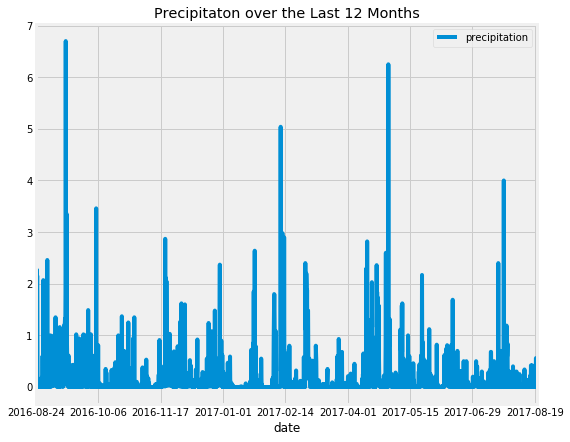

In [15]:
# Sort the dataframe by precipitation and plot
precipitaton_df = precipitaton_df.sort_values(by='date')

plt.rcParams['figure.figsize'] = [8,7]
precipitaton_df.plot(y='precipitation', 
                     title="Precipitaton over the Last 12 Months")

plt.savefig("Plots/precipitation_plot.png")
plt.show()

In [16]:
# Statistical summary of dataframe
precipitaton_df.describe()

,precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [18]:
# Total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

# List of the stations and their observation counts in descending order
sel = [Measurement.station, 
       func.count(Measurement.station).label('station_counts')]
station_counts = session.query(*sel).\
                 group_by(Measurement.station).\
                 order_by(func.count(Measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Collect temperature observation data over the last 12 months, limit query to
# the most active station (station with the highest count)
most_active_station = station_counts[0]
sel = [Measurement.date, Measurement.tobs]
tobs_last_12_months = session.query(*sel).\
                      filter(Measurement.station == most_active_station[0]).\
                      filter(Measurement.date < last_day).\
                      filter(Measurement.date > twelve_months_ago)

In [20]:
# Loaad query results into a pandas dataframe
tempObs_df = pd.read_sql(tobs_last_12_months.statement, con=engine)

# Delete null values of temperature observation data
tempObs_df = tempObs_df.dropna()

# Edit column label and index
tempObs_df = tempObs_df.rename(columns={'tobs':'Temperature Observation\nData'})
tempObs_df = tempObs_df.set_index('date')

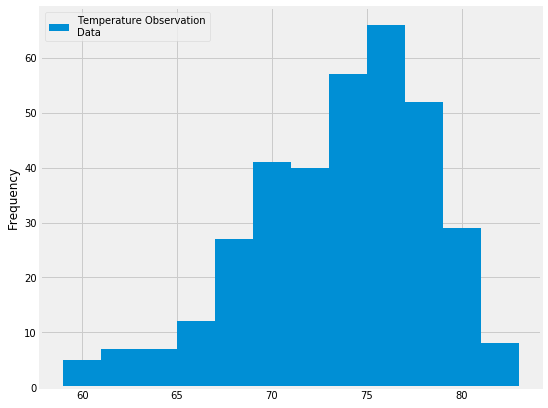

In [21]:
# Plot data as a histogram
tempObs_df.plot.hist(bins=12)
plt.savefig("Plots/temperature_histogram.png")
plt.show()